In [25]:
# a simple PLL implementation

# Relevant docs
#  Windowed-Sinc filters: https://www.analog.com/media/en/technical-documentation/dsp-book/dsp_book_Ch16.pdf
#  https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.windows.blackman.html
#  https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.oaconvolve.html
#  https://numpy.org/devdocs/reference/generated/numpy.polyfit.html
#  https://numpy.org/doc/2.1/reference/random/generated/numpy.random.Generator.normal.html

In [26]:
import numpy as np
from numpy import fft
from scipy import signal as sig
from scipy import linalg 
from matplotlib import pyplot as plt

# initialize the random number generator
rng = rng = np.random.default_rng()


In [27]:
# To design a windowed-sinc, two parameters must be selected: the cutoff
# frequency, fc, and the length of the filter kernel, M. The cutoff frequency 
# is expressed as a fraction of the sampling rate, and therefore must be between
# 0 and 0.5. The value for M sets the roll-off according to the approximation:
#    M = 4 / BW
# where BW is the width of the transition band, measured from where the curve
# just barely leaves one, to where it almost reaches zero (say, 99% to 1% of the
# curve). The transition bandwidth is also expressed as a fraction of the
# sampling frequency, and must between 0 and 0.5.

# The windowed-sinc filter kernel. The cutoff frequency, fC, is expressed as a
# fraction of the sampling rate, a value between 0 and 0.5. The length of the filter
# kernel is determined by M, which must be an even integer. The sample number
# i, is an integer that runs from 0 to M, resulting in M+1 total points in the filter
# kernel. The constant, K, is chosen to provide unity gain at zero frequency. To
# avoid a divide-by-zero error, for i = M/2, use h[i] = 2 * π * fc * K.

# For the filter to have unity gain at DC, the constant
# K must be chosen such that the sum of all the samples is equal to one. In
# practice, ignore K during the calculation of the filter kernel, and then normalize
# all of the samples as needed. 


In [28]:
BW_Hz = 8
Fc_Hz = 50

# 
fs = 16e3 # Sa/sec

bw = BW_Hz / fs   # FIXME
fc = Fc_Hz / fs
M = int(np.round(4 / bw))  # Eqn 16-3
if M % 2 == 1:
    M = M + 1
print(f"{M=}")

M=8000


8001 float64 1.0000000000000004
-4000.0 4000.0


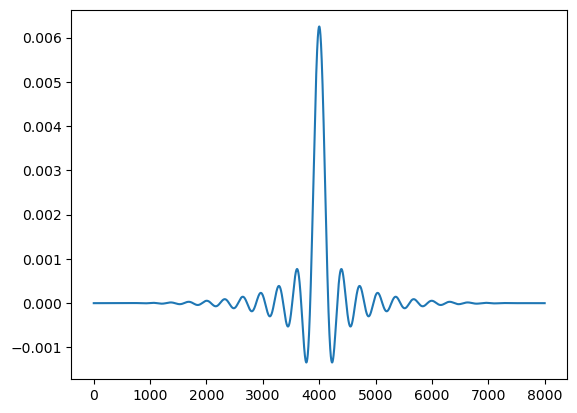

In [29]:
# this is straight from Eqn 16-4
h = np.zeros(M + 1)
ms = []
for i in range(0, M + 1):  # i runs from 0 to M+1
    m = i - M / 2
    ms.append(m)
    if m == 0:
        h[i] = 2 * np.pi * fc
    else:
        h[i] = (np.sin(2 * np.pi * fc * m) / m) * (
            0.42
            - 0.5 * np.cos((2 * np.pi * i) / M)
            + 0.08 * np.cos((4 * np.pi * i) / M)
        )
h /= np.sum(h)

print(h.size, h.dtype, np.sum(h))
print(np.min(ms), np.max(ms))
plt.plot(h)
plt.show()

-4000.0 4000.0


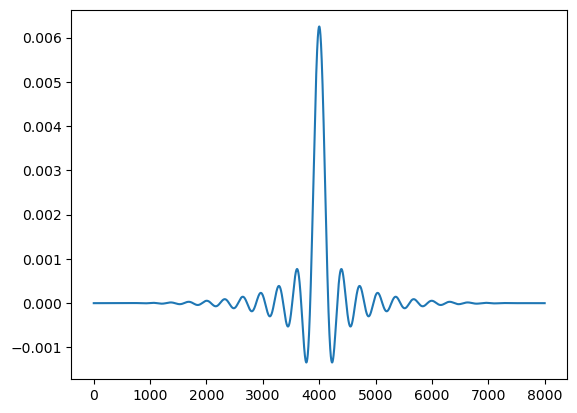

1.0000000000009763


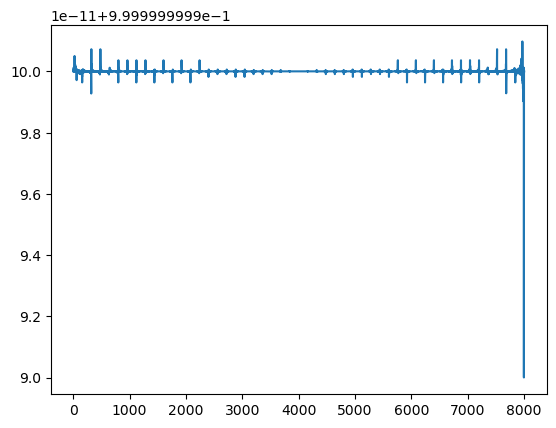

In [30]:
win = sig.windows.blackman(M + 1, sym=True)  # symetric for filter kernels

iii = np.linspace(-M / 2, +M / 2, M + 1, endpoint=True)
print(np.min(iii), np.max(iii))


ss = (
    np.sinc(2 * fc * iii) * win
)  # numpy's sinc is normalized, i.e. multiplys the argument by pi

ss /= np.sum(ss)

plt.plot(ss)
plt.show()

e = h / ss
print(np.max(np.abs(e)))
plt.plot(e)
plt.show()

h = ss

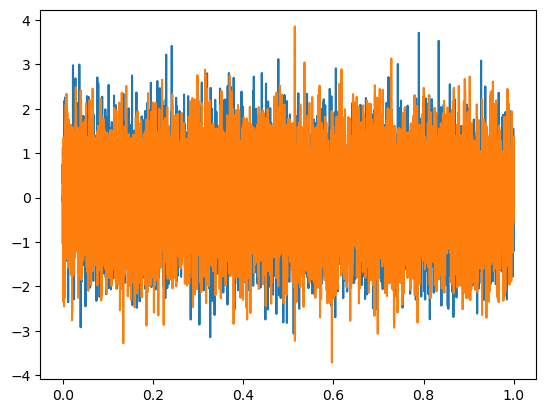

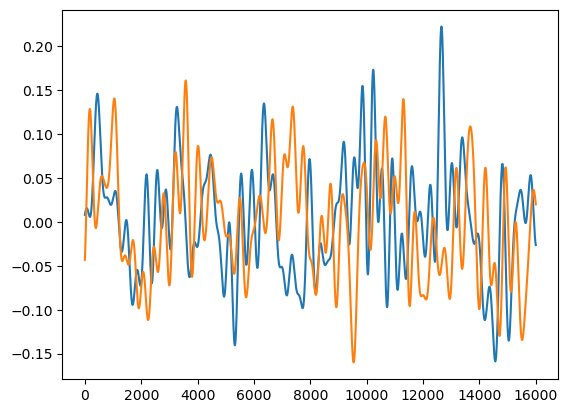

(16000,) complex128


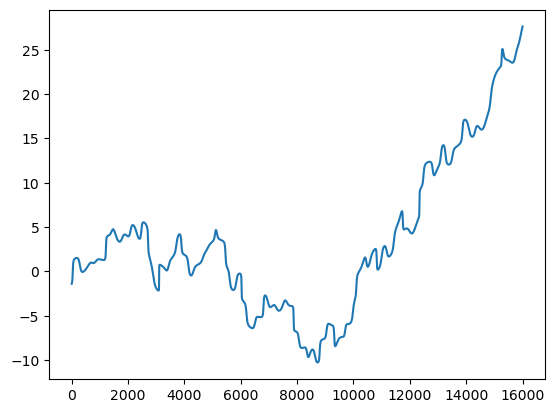

-0.7872707556778106 2.688130161245424


In [ ]:
fs = 16e3 # Sa/sec
f0 = 1.5e3 # Hz
ff = f0 + 5
duration = 1 # sec
t = np.arange(fs * duration)/fs

tx = np.exp(2j * np.pi * ff * t)

# channel model
rx = tx/5 + rng.normal(0, 1, tx.shape)  # FIXME 

# rx
lo = np.exp(2j * np.pi * f0 * t).conj()
xy = lo * rx.real

s = slice(None, None)
plt.plot(t[s], xy[s].real)
plt.plot(t[s], xy[s].imag)
plt.show()

xy_lp = sig.oaconvolve(xy, h, mode='same')
plt.plot(xy_lp[s].real)
plt.plot(xy_lp[s].imag)
plt.show()
print(xy_lp.shape, xy_lp.dtype)

a = np.unwrap(np.angle(xy_lp))
plt.plot(a)
plt.show()

t = np.arange(len(a)) / fs
p = np.polyfit(t, a, deg=1)  # this will be in radians
print(p[1]/(2*np.pi), p[0]/(2*np.pi))
